In [16]:
import numpy as np
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"

# 4. Cancer de laringe.

## Hagamos un pequeño análisis exploratorio de los datos.

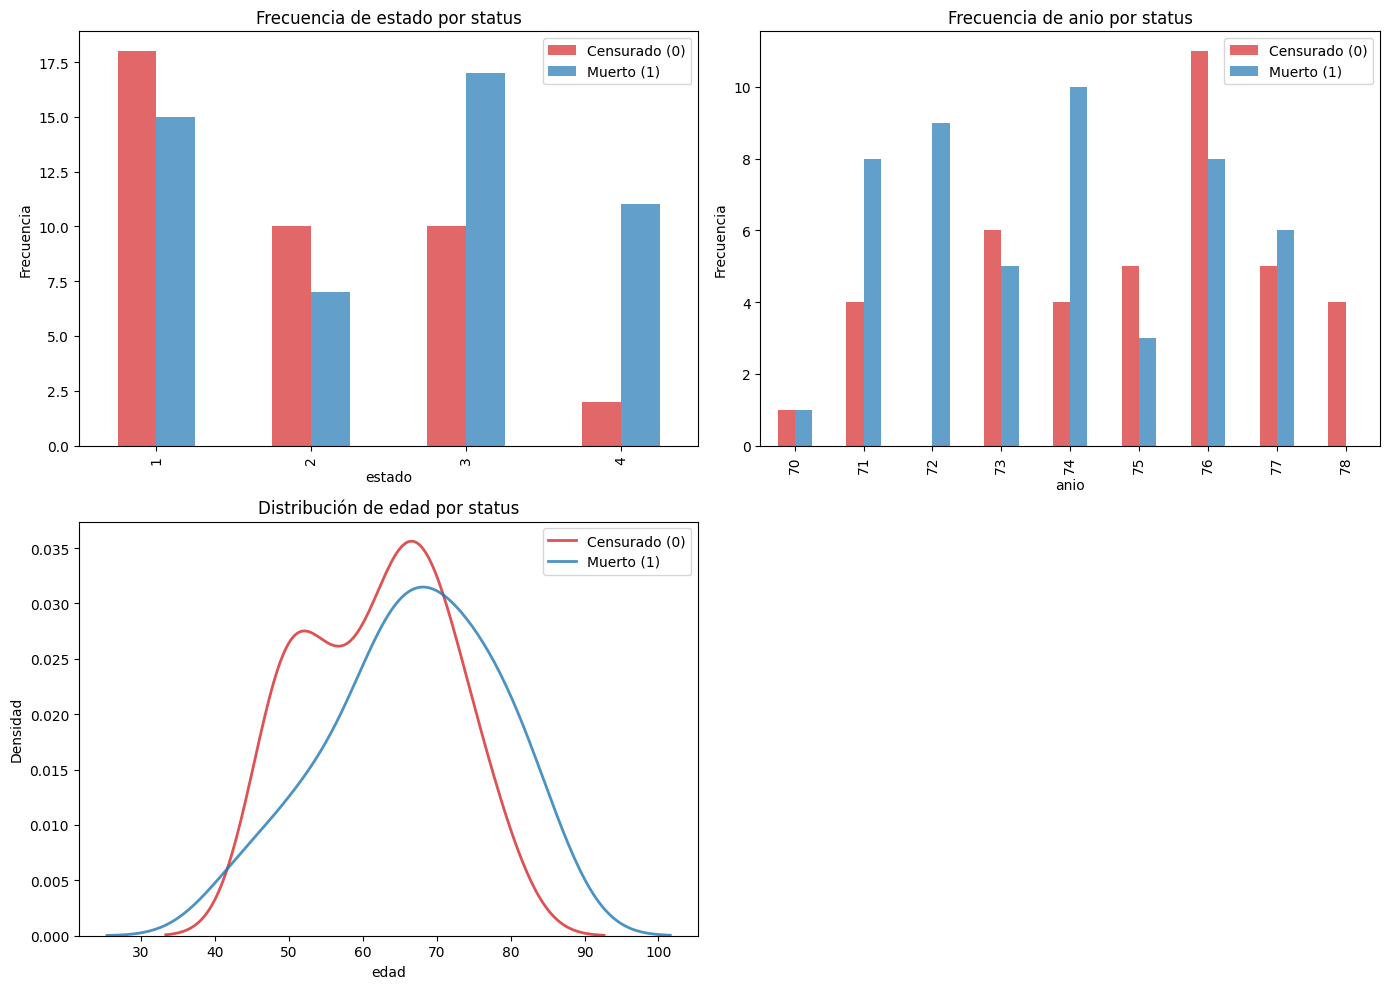

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.read_csv(
    'cancerLaringe.txt',
    sep='\s+',
    header=None,
    names=["id", "estado", "tiempo", "edad", "anio", "status"]
)

df = df.drop(columns=["id"])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

categorical_vars = ['estado', 'anio']
for i, var in enumerate(categorical_vars):
    group_counts = df.groupby([var, 'status']).size().unstack(fill_value=0)
    group_counts.plot(
        kind='bar',
        ax=axs[0, i],
        color=['tab:red', 'tab:blue'],
        alpha=0.7
    )
    axs[0, i].set_xlabel(var)
    axs[0, i].set_ylabel('Frecuencia')
    axs[0, i].set_title(f'Frecuencia de {var} por status')
    axs[0, i].legend(['Censurado (0)', 'Muerto (1)'])

continuous_vars = ['edad']
for i, var in enumerate(continuous_vars):
    for status_val, status_label, color in [(0, 'Censurado (0)', 'tab:red'), (1, 'Muerto (1)', 'tab:blue')]:
        data_subset = df[df['status'] == status_val][var]
        if len(data_subset) > 1:  
            numeric_data = pd.to_numeric(data_subset, errors='coerce').dropna()
            if len(numeric_data) > 1:
                sns.kdeplot(data=numeric_data, ax=axs[1, i], color=color, alpha=0.8, linewidth=2, label=status_label)
    
    axs[1, i].set_xlabel(var)
    axs[1, i].set_ylabel('Densidad')
    axs[1, i].set_title(f'Distribución de {var} por status')
    axs[1, i].legend()

fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()


## Parece que sí hay alguna tendencia en las covariables en cuanto a su influencia en la muerte, es decir, las covariables parecen tener información valiosa.
## Veamos las curvas KM para la variable "estado", que tiene 4 categorías:

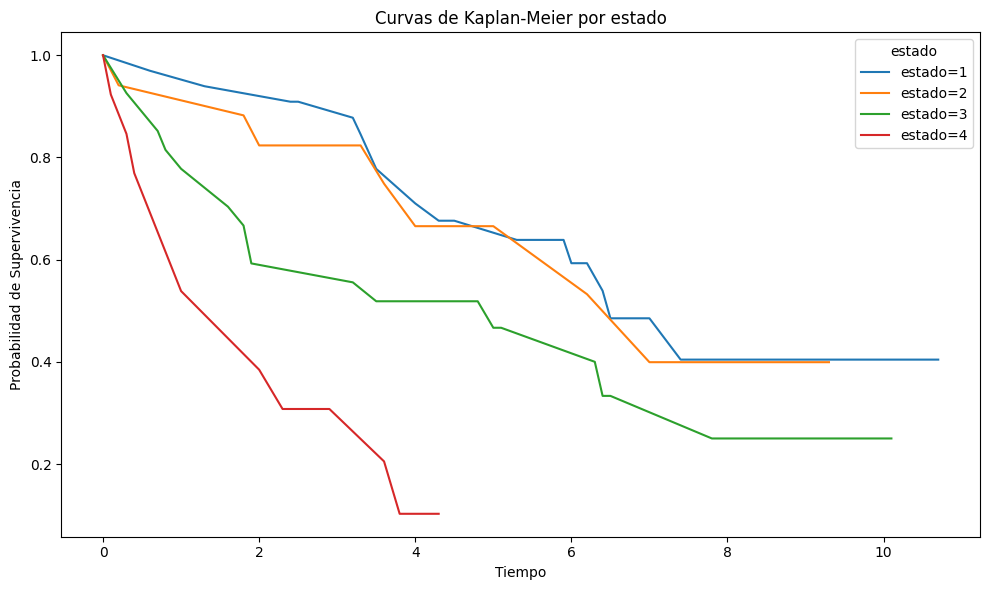

Logrank test pairwise para estado:
  estado=1 vs estado=2: p-value = 0.8663
  estado=1 vs estado=3: p-value = 0.0801
  estado=1 vs estado=4: p-value = 0.0000
  estado=2 vs estado=3: p-value = 0.2256
  estado=2 vs estado=4: p-value = 0.0007
  estado=3 vs estado=4: p-value = 0.0226


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns
import matplotlib.pyplot as plt


df['tiempo'] = pd.to_numeric(df['tiempo'], errors='coerce')
df['status'] = pd.to_numeric(df['status'], errors='coerce')
df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
df['anio'] = pd.to_numeric(df['anio'], errors='coerce')

df_clean = df.dropna()

var = 'estado'
kmf = KaplanMeierFitter()

unique_values = sorted(df_clean[var].unique())
palette = sns.color_palette("tab10", n_colors=len(unique_values))

plt.figure(figsize=(10, 6))
for idx, value in enumerate(unique_values):
    mask = df_clean[var] == value
    tiempo = df_clean.loc[mask, 'tiempo']
    status = df_clean.loc[mask, 'status']
    kmf.fit(tiempo, event_observed=status, label=f"{var}={value}")
    # Plot with seaborn lineplot for consistent style
    sns.lineplot(
        x=kmf.survival_function_.index,
        y=kmf.survival_function_[kmf._label],
        label=f"{var}={value}",
        color=palette[idx]
    )

plt.title('Curvas de Kaplan-Meier por estado')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de Supervivencia')
plt.legend(title=var)
plt.tight_layout()
plt.show()

# Logrank test para comparar los grupos de 'estado'
if len(unique_values) == 2:
    group1 = df_clean[df_clean[var] == unique_values[0]]
    group2 = df_clean[df_clean[var] == unique_values[1]]
    results = logrank_test(
        group1['tiempo'],
        group2['tiempo'],
        event_observed_A=group1['status'],
        event_observed_B=group2['status']
    )
    print(f"Logrank test para {var}: p-value = {results.p_value:.4f}")
elif len(unique_values) > 2:
    print(f"Logrank test pairwise para {var}:")
    for i in range(len(unique_values)):
        for j in range(i+1, len(unique_values)):
            group1 = df_clean[df_clean[var] == unique_values[i]]
            group2 = df_clean[df_clean[var] == unique_values[j]]
            results = logrank_test(
                group1['tiempo'],
                group2['tiempo'],
                event_observed_A=group1['status'],
                event_observed_B=group2['status']
            )
            print(f"  {var}={unique_values[i]} vs {var}={unique_values[j]}: p-value = {results.p_value:.4f}")


## Parece que al menos en la variable 'estado', tenemos riesgos proporcionales (aunque edo 1 y edo2 se crucen un poco.)
## Es claro que al aumentar el estado o la "gravedad" de la enfermdad, la probabilidad de sobrevivir disminuya.
## Ajustemos un model de COX-PH con todas las variables

In [ ]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
import matplotlib.pyplot as plt

cph = CoxPHFitter()

cox_data = df_clean.copy()

cph.fit(cox_data, duration_col='tiempo', event_col='status')

print("Cox Proportional Hazards Model Summary:")
print("=" * 50)
cph.print_summary()

print("\nProportional Hazards Test:")
print("=" * 30)
ph_test = proportional_hazard_test(cph, cox_data)
print(ph_test)


Cox Proportional Hazards Model Summary:


<lifelines.CoxPHFitter: fitted with 90 total observations, 40 right-censored observations>
             duration col = 'tiempo'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 90
number of events observed = 50
   partial log-likelihood = -188.95
         time fit was run = 2025-09-29 02:43:39 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
estado     0.50      1.65      0.14            0.23            0.78                1.25                2.18
edad       0.02      1.02      0.01           -0.01            0.05                0.99                1.05
anio      -0.00      1.00      0.07           -0.15            0.14                0.86                1.16

           cmp to     z      p  -log2(p)
covariate                               
estado       0.00  3.56 <0.005     11.39
edad         0.00  1.57   0.12      3.11
anio         0.00 -0.02   0.98      0.03
---
Concordance = 0.68
Partial AIC = 383.90
log-likelihood ratio test = 15.82 on 3 df
-log2(p) of ll-ratio test = 9.66


Proportional Hazards Test:
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 90 total observations, 40 right-censored observations>
         test_name = proportional_hazard_test

---
        test_statistic    p  -log2(p)
anio              0.35 0.56      0.84
edad              0.99 0.32      1.64
estado            3.71 0.05      4.21


## La concordancia de 0.68 es relativamente alta y los p valores nos indican que las covariables son significativas.

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 90 total observations, 40 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
anio   km              0.36 0.55      0.86
       rank            0.35 0.56      0.84
edad   km              0.91 0.34      1.55
       rank            0.99 0.32      1.64
estado km              3.79 0.05      4.28
       rank            3.71 0.05      4.21



1. Variable 'estado' failed the non-proportional test: p-value is 0.0515.

   Advice: with so few unique values (only 4), you can include `strata=['estado', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



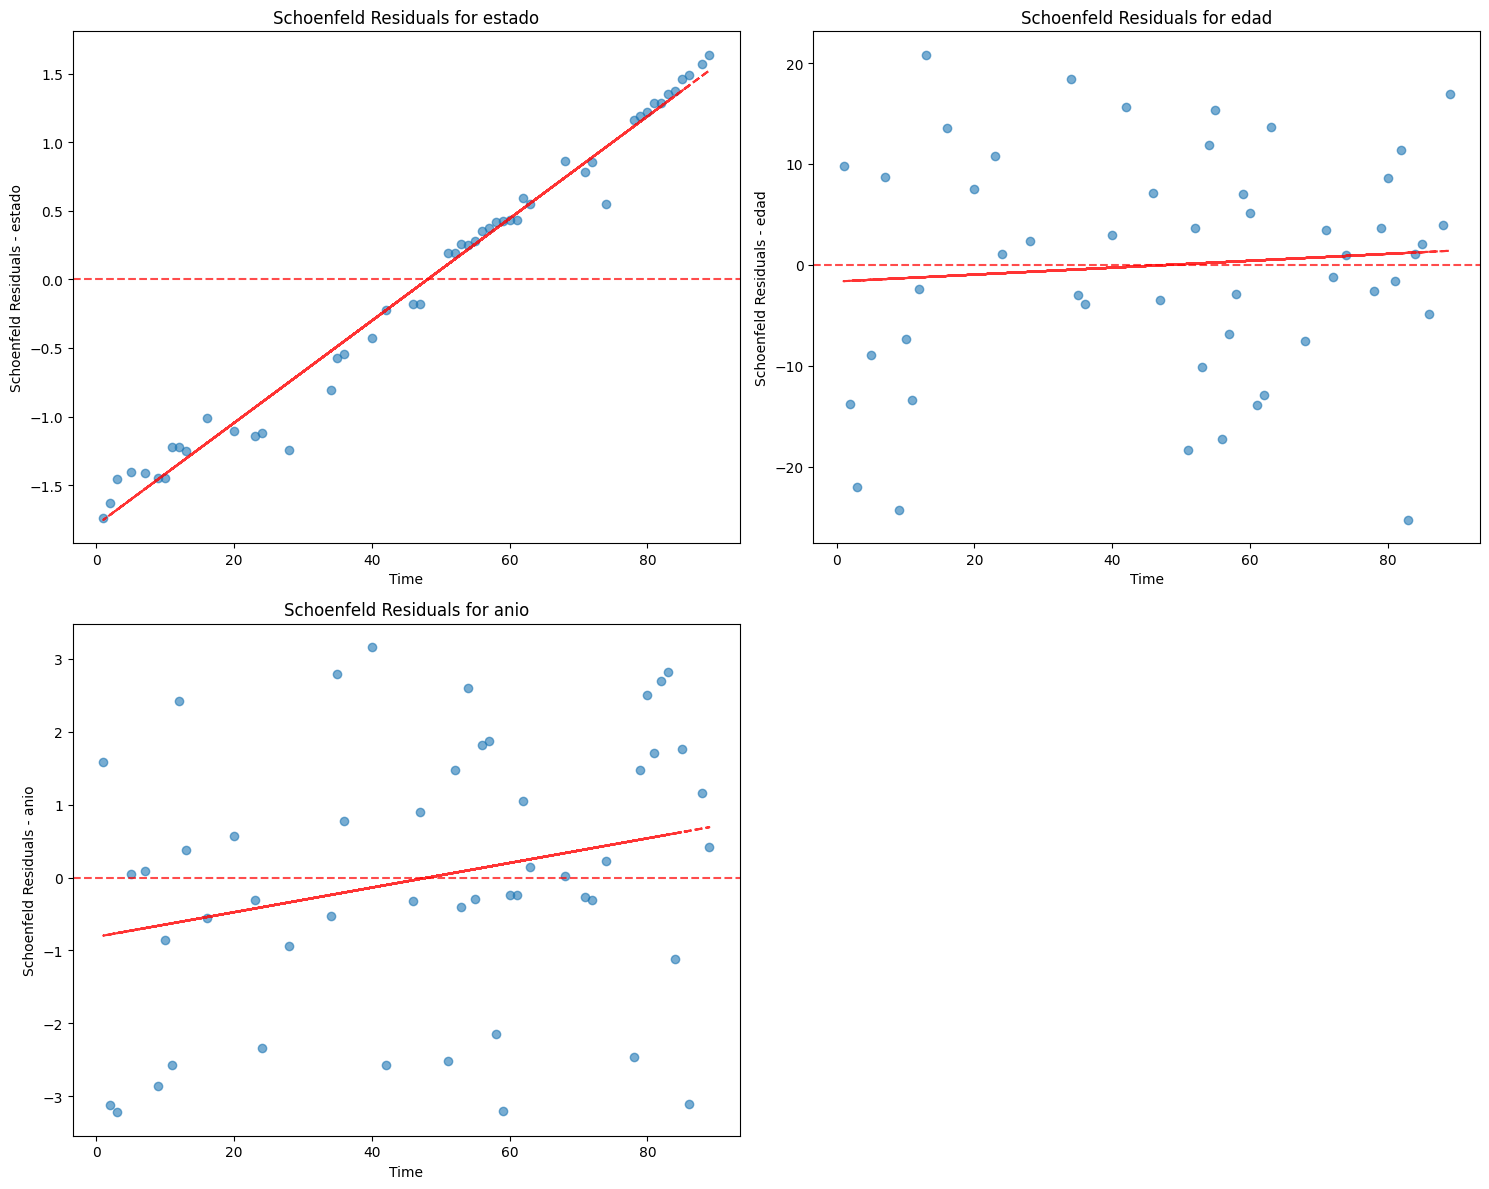

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=False)

from lifelines.utils import concordance_index
import numpy as np

variables = ['estado', 'edad', 'anio']
for i, var in enumerate(variables):
    if i < len(axes):
        # Get residuals for this variable
        residuals = cph.compute_residuals(cox_data, kind='schoenfeld')
        
        if var in residuals.columns:
            # Plot residuals vs time
            axes[i].scatter(residuals.index, residuals[var], alpha=0.6)
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel(f'Schoenfeld Residuals - {var}')
            axes[i].set_title(f'Schoenfeld Residuals for {var}')
            
            # Add trend line
            z = np.polyfit(residuals.index, residuals[var], 1)
            p = np.poly1d(z)
            axes[i].plot(residuals.index, p(residuals.index), "r--", alpha=0.8)

if len(variables) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


## Podemos ver que los residuales Schoenfeld de edad y año son relativamente horizontales, con p valores altos, por lo cual cumplen los riesgos proporcionales.

## La variable estado no cumple con los riesgos proporcionales con un pvalor 0.05 < $\alpha =0.1$. Esto tiene algo de sentido porque el estado del cáncer aumenta o disminuye la probabilidad de supervivencia.
## Ya que la variable "estado" es categórica, no se puede hacer una transformación logarítmica, lo que se tendría que hacer es un COX estratificado.

## Veamos los residuales martingala para las variables continuas:

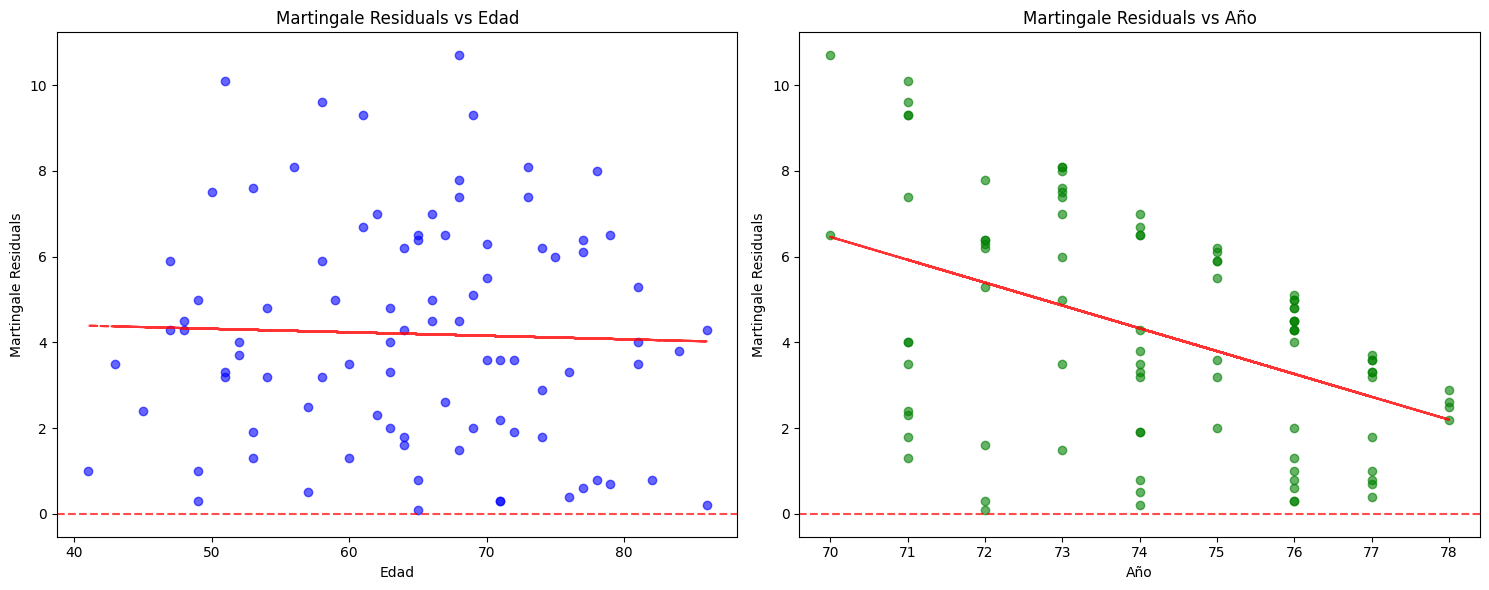

In [ ]:

martingale_residuals_df = cph.compute_residuals(cox_data, kind='martingale')

if martingale_residuals_df.shape[1] == 1:
    martingale_residuals = martingale_residuals_df.iloc[:, 0]
else:
    martingale_residuals = martingale_residuals_df.iloc[:, 0]

cox_data_with_residuals = cox_data.copy()
cox_data_with_residuals['martingale_residuals'] = martingale_residuals

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(cox_data_with_residuals['edad'], cox_data_with_residuals['martingale_residuals'], 
                alpha=0.6, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Martingale Residuals')
axes[0].set_title('Martingale Residuals vs Edad')

z_edad = np.polyfit(cox_data_with_residuals['edad'], cox_data_with_residuals['martingale_residuals'], 1)
p_edad = np.poly1d(z_edad)
axes[0].plot(cox_data_with_residuals['edad'], p_edad(cox_data_with_residuals['edad']), "r--", alpha=0.8)

axes[1].scatter(cox_data_with_residuals['anio'], cox_data_with_residuals['martingale_residuals'], 
                alpha=0.6, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Martingale Residuals')
axes[1].set_title('Martingale Residuals vs Año')

z_anio = np.polyfit(cox_data_with_residuals['anio'], cox_data_with_residuals['martingale_residuals'], 1)
p_anio = np.poly1d(z_anio)
axes[1].plot(cox_data_with_residuals['anio'], p_anio(cox_data_with_residuals['anio']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()



## Los residuales martingala tienen tendencias lineales, por lo cual se cumple el supuesto de linealidad.

## Veamos los residuales de Cox-Snell, que nos dan una indicación de la bondad de ajuste.

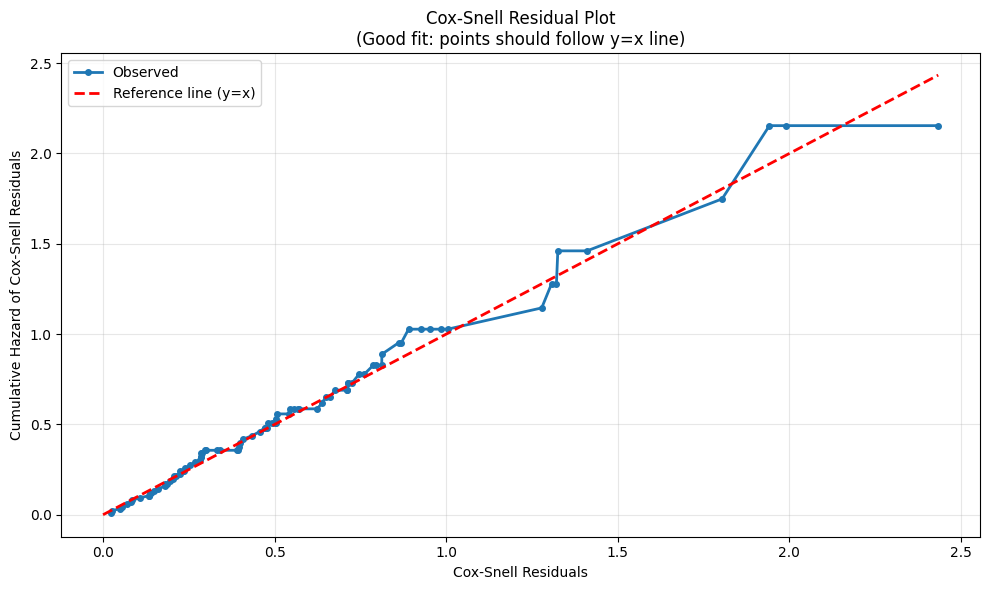

In [ ]:

from lifelines import KaplanMeierFitter

baseline_hazard = cph.baseline_cumulative_hazard_
linear_predictor = cph.predict_partial_hazard(cox_data)
cox_snell_residuals = baseline_hazard.loc[cox_data['tiempo'].values].iloc[:, 0].values * linear_predictor.values

cox_snell_df = pd.DataFrame({
    'cox_snell_residuals': cox_snell_residuals,
    'event': cox_data['status'].values
})

cox_snell_df = cox_snell_df.sort_values('cox_snell_residuals').reset_index(drop=True)

kmf_cs = KaplanMeierFitter()
kmf_cs.fit(cox_snell_df['cox_snell_residuals'], 
           event_observed=cox_snell_df['event'], 
           label='Cox-Snell Residuals')

cumulative_hazard_cs = -np.log(kmf_cs.survival_function_)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

time_points = kmf_cs.survival_function_.index
cum_hazard_values = cumulative_hazard_cs.iloc[:, 0].values

if len(time_points) > 0 and time_points[0] == 0 and cum_hazard_values[0] == 0:
    time_points = time_points[1:]
    cum_hazard_values = cum_hazard_values[1:]

ax1.plot(time_points, cum_hazard_values, 
         'o-', markersize=4, linewidth=2, label='Observed')

max_residual = max(time_points.max(), cox_snell_df['cox_snell_residuals'].max())
ax1.plot([0, max_residual], [0, max_residual], 'r--', linewidth=2, label='Reference line (y=x)')

ax1.set_xlabel('Cox-Snell Residuals')
ax1.set_ylabel('Cumulative Hazard of Cox-Snell Residuals')
ax1.set_title('Cox-Snell Residual Plot\n(Good fit: points should follow y=x line)')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Los residuales Cox-Snell ajustan relativamente bien a la línea de referencia, mientras más pegado a la identidad $y=x$, podemos decir que es mejor el fit del modelo. En este caso podemos decir que el modelo es adecuado, quizá excepto en las colas.

## Podemos hacer un Kolmogorov-Smirnov para tener más certeza sobre la bondad de ajuste:

In [23]:
# Prueba de Kolmogorov-Smirnov para los residuales de Cox-Snell
# Los residuales de Cox-Snell deberían seguir una Exp(1) si el modelo ajusta bien
from scipy import stats
ks_stat, ks_p_value = stats.kstest(cox_snell_residuals, 'expon', args=(0, 1))
print(f"\nPrueba de Kolmogorov-Smirnov para los residuales de Cox-Snell:")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"Valor p: {ks_p_value:.4f}")
print(f"Nivel de significancia: α = 0.05")


Prueba de Kolmogorov-Smirnov para los residuales de Cox-Snell:
Estadístico KS: 0.2663
Valor p: 0.0000
Nivel de significancia: α = 0.05


## A un Nivel de significancia: α = 0.05 Se rechaza H₀: los residuales de Cox-Snell se desvían de la distribución Exp(1)
## El modelo podría no ajustar bien al nivel α = 0.05
## Por lo tanto habría que hacer alguna transformación o estratificar para poder decir que tenemos un buen modelo.